# Hazard Curves for PTHA

The goal of probabilistic tsunami hazard assessment (PTHA) is often to create a hazard map that shows what regions of a community are most at risk and that indicates in some manner the annual probability that inundation will occur above some level in these regions.  The notebook [Hazard_Maps.ipynb](Hazard_Maps.ipynb) shows some hazard maps from a recent study of Crescent City, CA.

A key ingredient in making any such map is the *hazard curve* computed at many geographical locations (typically at each point on some grid of points covering the community of interest).  The focus in this notebook is understanding how one such hazard curve is constructed.  So we are considering a *fixed geographic location* and looking at the probability that the maximum inundation depth exceeds some value $h$ as $h$ varies.  

Note that this probability $P(h)$ will be a non-increasing function of $h$, i.e., if $h_1 < h_2$ then $P(h_1) \geq P(h_2)$ since any event that inundates above depth $h_2$ also inundates above depth $h_1$.

Also note that $P(0)$ is the annual probability that there is inundation deeper than $h=0$, i.e., the probability that there is any flooding at all.  If $P(0) = 0$ then $P(h) = 0$ for all $h>0$ and this is a point that has 0 probability of ever getting wet, i.e., it is completely out of any possible inundation zone.  

If $P(0) > 0.01$ at this location then the annual probability is greater than $0.01$ that this point will get wet.  Such a point is sometimes said to be in the 100-year flood zone.

#### Set up some things needed for this notebook:

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [13]:
from __future__ import print_function
from ipywidgets import interact, widgets
from IPython.display import Image, display, Markdown
import sys,os

import hazard_maps_functions as HM
import hazard_curve_functions as HC

### Poisson process rates and probabilities

For the purposes of this tutorial, we assume that we are considering a discrete set of possible events, each of which is a hypothetical earthquake with some specified sea floor motion. Associated with each event we have a rate $\lambda$ and we assume that occurance of this event is a Poisson process with this rate.  If $\lambda$ is in units of average number of occurances per year (typically much less than 1), then the probability of this event happening at least once in a given time period $\Delta t$ years is:

$$
p = 1 - e^{-\lambda \Delta t}.
$$

If we want to compute the annual probability of getting flooding to some level, then we can restrict our attention to $\Delta t = 1$ year and so $p = 1 - \exp(-\lambda)$.

Note that if $\lambda$ is small then Taylor series expansion shows that 

$$
\begin{split}
p &= 1 - e^{-\lambda} \\
&= 1 - \left(1 - \lambda + \frac 1 2 \lambda^2 + \cdots\right) \\
&= \lambda - \frac 1 2 \lambda^2 + \cdots\\
&\approx \lambda
\end{split}
$$

So for very small $\lambda$ we can view $\lambda$ as the annual probability of the event, but this would break down for larger $\lambda$.  For example suppose $\lambda = 2$, meaning on average the event happens twice per year.  Then annual probability is obviously not 2.  In this case $p$, the annual probability of the event happening *at least* once, would be $p = 1 - \exp(-2) \approx 0.86$ in this case.

The **return period** is defined as $R_p = 1/\lambda$.

### Combining events

Now suppose there are two possible events (hypothetical earthquakes) with rates $\lambda_1$ and $\lambda_2$.  Then the combined rate is $\lambda_1 + \lambda_2$ and the probability that *at least* one of them occurs (at least once) in time $\Delta t = 1$ year is given by 

$$
p = 1 - e^{-(\lambda_1 + \lambda_2)}
$$

Note that we could also compute these using the probabilities $p_1 = 1 - \exp(-\lambda_1)$ and $p_2 = 1 - \exp(-\lambda_2)$.  The probability that **neither** event occurs is the product of $(1-p_1)$ and $(1-p_2)$ and so the probaiblity that at least one event occurs is

$$
p = 1 - (1-p_1)(1-p_2) = 1 - e^{-\lambda_1}e^{-\lambda_2} = 1 - e^{-(\lambda_1 + \lambda_2)}
$$

From this we can also compute that $p = p_1 + p_2 - p_1p_2$.  So if $p_1$ and $p_2$ are both very small then $p \approx p_1 + p_2$, but for larger probabilities (or when combining many more events) it is necessary to use the formulas above.  For $n$ events the combined rate is simply $\lambda_1 + \lambda_2 + \cdots + \lambda_n$.

### Hazard curve for a single event

First we consider the simplest case where only one possible event might occur.  We assume that the occurance of this event is a Poisson process with some rate $\lambda_1 = 0.001$ events per year (i.e., with a 1000-year return time), in which case  $p_1 = \exp(-\lambda_1) \approx 0.0009995$.

Recall that we are considering some particular fixed location in the community of interest, and suppose our tsunami simulation shows that the maximum depth of inundation at this point will be $h_1 = 1.5 m$ if this event occurs (measured in meters of water depth).  Then we can plot the annual probability $P(h)$ that flooding will exceed the value $h$ as a function of $h$ (the exceedance value).  This is a simple piecewise constant function since $P(h) = p_1 = \exp(-\lambda_1)$ for any $h < h_1$ and $P(h) = 0$ for any $h > h_1$.  This plot is shown below.  

Note that since we are dealing with very small probabilities and it is important to distinguish between values like 0.01 (100-year flood) and 0.001 (1000-year flood), it is best to plot this using a logarithmic scale in $p$.  We do this in the plots on the left below.  Note that for all $h>h_1 = 1.5$ in the plot below, the function value $P(h) = 0$ does not show up since $\log(0) = -\infty$.   

The plots on the right show the same data plotted with a linear scale in p, since this is somewhat easier to read and understand for these simple examples.

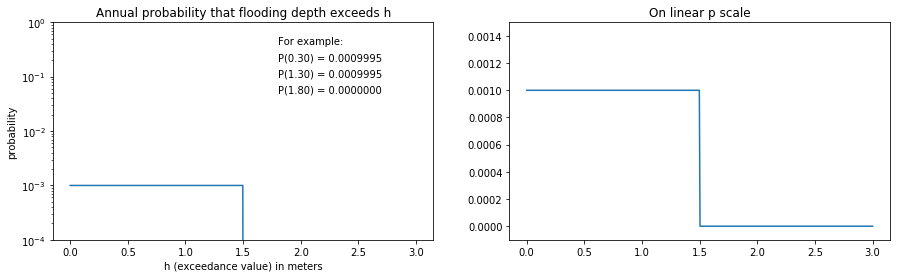

In [14]:
lambda1 = 0.001
h1 = 1.5
E1 = [lambda1,h1]
event_list = [E1]  # only one event in this example
h_ev,p_ev = HC.hazard_curve(event_list, 3)
fig = HC.plot_hazard_curve(h_ev,p_ev)

### Combining two events

The plot above is the hazard curve if we assume only one possible event might happen.  What if there are two possible earthquakes that could happen, each of which would cause flooding to different maximum depths, call them $h_1$ and $h_2$.  The events might also have different annual rates, call these $\lambda_1$ and $\lambda_2$.  We will assume that they are independent, meaning that if one happens or not has no effect on whether the other occurs.  This is a good assumption if one event is a potential earthquake on the Cascadia subduction zone and the other is a potential earthquake on a different subduction zone.  It is perhaps less justified if the two events are two different possible earthquakes in the same place.  The occurrance of one Magnitude 9 earthquake on CSZ might eliminate the possibility of another M9 event, or it might increase the occurance of an M8 event as an aftershock.  But we will not consider this more complicated case and assume that they are independent events.

The plots below show the new hazard curve if we assume the first event $E_1$ is as above, and we add a new event $E_2$ with $\lambda_2 = 0.003$ and $h_2 = 1.0 m$.

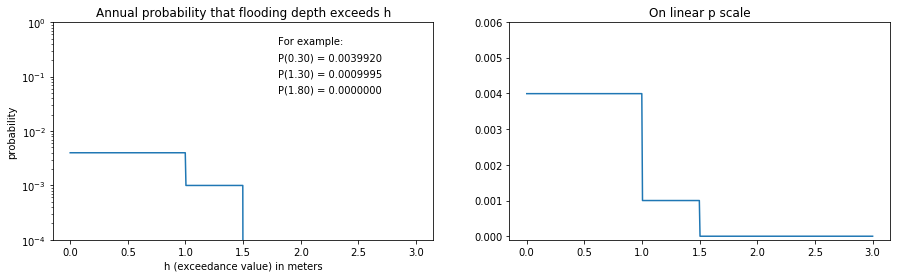

In [15]:
E2 = [0.003, 1.0]      # the second event
event_list = [E1, E2]  # assumes E1 already defined in previous cell
h_ev,p_ev = HC.hazard_curve(event_list, 3)
fig = HC.plot_hazard_curve(h_ev,p_ev)

Note that the probability of exceeding $1.3 m$, for example, is still $0.001$ since this happens only if Event 1 occurs.  The probability of exceeding $0.3$ meters (or any $h$ below $1.0 m$) has now increased to $0.003992$ since this level is exceeded if *either* Event 1 or Event 2 occurs.  Since Event 1 has annual rate $0.001$ and Event 2 has annual rate $0.003$, the probability that at least one of them occurs in a year is approximately equal to the combined rate, which is $\lambda_1 + \lambda_2 = 0.004$. 

The plot below allows you to vary the rate $\lambda_2$ and/or the maximum flooding $h_2$ for a second event and see how this affects the hazard curve.  In each case the first event $E_1$ is fixed with $\lambda_1=0.001$ and $h_1 = 1.5$.

In [16]:
interact(HC.makefig, h2=widgets.FloatSlider(min=0.5,max=2.5,step=0.5,value=0.5,description="inundation depth h2"),
         lambda2=widgets.FloatSlider(min=5e-4,max=5e-3,step=0.0005,value=0.0005,
                                  readout_format='.4f',description="rate lambda2"));

#### Note the following:

- Use the slider bar to vary $h_2$ or $\lambda_2$ and observe how the plots change.
- Adding the new event $E_2$ causes a new discontinuity in the hazard curve at the value $h_2$ (or adds to the discontinuity at the point $h=1.5$ in the case $h_2 = h_1 = 1.5$).
- The vertical jump in $p$ at the point $h_2$ introduced by this event is *approximately* equal to $p_2 = 1-\exp(-\lambda_2)~~$ (Exactly $p_2$ if $h_2 > h_1$.)
- Try changing $\lambda_2$ when $h_2 < h_1$ and also when $h_2 > h_1$ and see how it affects the hazard curve in each case.

### Multiple events

Now suppose there are additional events $E_3, E_4, \ldots$, where Event $E_k$ has annual probability $p_k$ of occurring and would cause flooding to depth $h_k$.   Adding each event will cause a new jump in the hazard curve at $h=h_k$ with the vertical magnitude *approximately* equal to $p_k$.  The actual probability of *at least* one event $E_1$ through $E_n$ occuring is computed by generalizing what we did above.  The probability that *none* of the independent events occurs is
$$
1 - \hat p = (1-p_1)(1-p_2)\cdots(1-p_n) = e^{-\lambda_1}e^{-\lambda_2}\cdots e^{-\lambda_n} = e^{-(\lambda_1+\lambda_2+\cdots \lambda_n)}
$$
and so 
$$
\hat p = 1 - (1-p_1)(1-p_2)\cdots(1-p_n) = 1 - e^{-(\lambda_1+\lambda_2+\cdots \lambda_n)}.
$$
For any excedance value $h$, we can compute the probability $P(h)$ that we get flooding at this point by combining the probabilities for all the events $E_k$ for which $h_k > h$.  For example, if only events $E_2, E_5$, and $E_9$ exceed $h$, then
$$
P(h) = 1 - (1-p_2)(1-p_5)(1-p_9) = 1 - e^{-(\lambda_2+\lambda_5+\lambda_9)}.
$$

The next hazard curve shows an example with 10 events, each with the same annual rate $\lambda_k = 0.001$ but with different maximum flooding depths (chosen as random numbers in the interval from 0.5 to 2.5 meters).

### An example with many events

The next example shows a hazard curve computed from 10 events.  All events have the same rate, $\lambda_k = 0.002$ for $k=0,~1,~2,~\ldots,~9$, but the values $h_k$ vary between $0.5m$ and $2.5m$.  They are chosen as random numbers from a uniform distribution over this interval.

This might be viewed as a hazard curve arising from a single event with rate $\hat \lambda = 0.02$ but that has a range of different flooding levels (e.g. tsunamis from a single fault zone what has an earthquake every 50 years on average but for which the magnitude can vary considerably).  

Flooding depths h_k =  [ 2.35923219  1.13275111  0.86783762  0.90912056  1.63545006  1.69108941
  2.42902904  1.80635419  1.99781328  1.80713974]


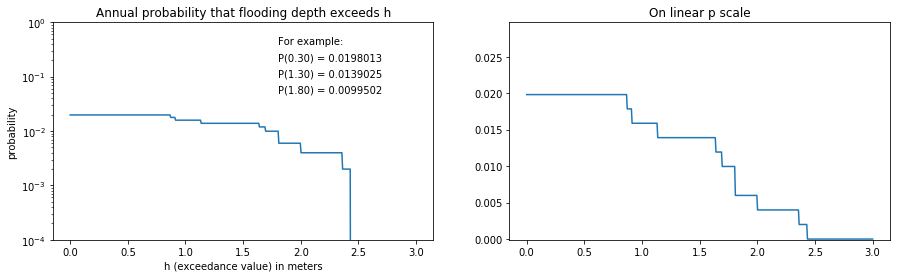

In [17]:
from numpy import random
random.seed(12345)  # seed the random number generator

event_list = []  # initialize to empty list
n_events = 10
random_h = 0.5 + 2*rand(n_events)  # rand(n) returns array of n random number in interval [0,1]
print("Flooding depths h_k = ",random_h)

for k in range(n_events):
    lambda_k = 0.002
    hk = random_h[k]
    Ek = [lambda_k,hk]
    event_list.append(Ek)   # add this event to the list
h_ev,p_ev = HC.hazard_curve(event_list, 3)
fig = HC.plot_hazard_curve(h_ev,p_ev)

#### Note:

- On the linear scale plot, each event has nearly the same jump in $p$.  Not quite because of the discussion about combining multiple events, but nearly so.  Note the jump around $h = 1.8$ appears twice as big because there happen to be two events with $h_k$ very close together.  
- On the log scale the jumps look different because of the logarithmic scaling.
- The value $P(0) = 0.0198013$ (the constant value up to $h = \min_k(h_k)$) is not quite equal to $10 \lambda_k = 0.02$, again because of the rule discussed above for combining probabilities.  Instead it is equal to $1 - \exp(-0.02)$.
- If we had chosen $\lambda_k = -\log(1 - 0.002) \approx 0.002002$ then we would get $P(0) = 0.02$, but when dealing with such small probabilities this makes little difference in practice.

## Hazard curves for Crescent City

The notebook [Hazard_Maps.ipynb](Hazard_Maps.ipynb) shows some hazard curves from a recent study of Crescent City, CA. The figure below shows a different variant of some of these plots.  Hazard curves computed for several different locations in and around Crescent City, indicated by the red dot in the inset map.  Use the slider to view different locations.  

In each plot, the top green curve is the hazard curve computed when all events are taken into account.  The horizontal axis shows an "exceedance value", in this a depth of flooding, and the vertical axis shows the annual probability that this level will be exceeded.  Recall that zeta $(\zeta)$ represents the maximum depth of flooding onshore, or the maximum surface elevation during the tsunami at offshore points.

These figures show three curves.  The **green** hazard curve is obtained when all the events are included and is the full hazard curve that should be used to estimate annual probabilities.

The **red** hazard curve is the hazard curve that would result if we ignored the Cascadia Subduction Zone (CSZ) and only considered the far field sources (i.e. AASZ, KmSZ, KrSZ, SChSZ, and TOH).

The **blue** hazard curve shows the annual probabilities when considering CSZ alone, ignoring the far field sources.

At any given exceedance level, the total probability $p$ (green curve) is obtained by combining the far field probability $p_f$ and the Cascadia probability $p_c$ via the formula $p = 1 - (1-p_f)(1-p_c) = p_f + p_c - p_fp_c \approx p_f + p_c$ since all these probabilities are quite small.  Note that these curves are shown on a logarithmic scale.  

In [18]:
def show_hc(k):
    display(Image(HM.hc_split_plots[k],width=500))
    
interact(show_hc,k=widgets.IntSlider(min=0,max=len(HM.hc_split_plots)-1,value=0));

### Note the following on the plots above:

- The deepest inundation is associated with CSZ events (the red curve drops to zero probability at a smaller value of zeta, and beyond this the green line lies on top of the blue line for large values of zeta). 

- For small exceedance values zeta, the green curve lies nearly on top of the red curve.  This is because far field sources are much more likely than a CSZ event, and so the probability of low levels of flooding is dominated by the probability of far field events.

## Next steps

Next you should read the notebook [Hazard_Maps.ipynb](Hazard_Maps.ipynb) if you haven't already, 
to how these curves are combined into maps.

Then the notebook [Make_Hazard_Curves_and_Maps.ipynb](Make_Hazard_Curves_and_Maps.ipynb) gives more detail 
about how to actually implement this, using a sample data set for Crescent City.

See [Contents.ipynb](Contents.ipynb) for other notebooks.